In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

from tensorflow.keras.layers import Input, Dense, Add, Conv2D, LeakyReLU, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
IMG_WIDTH = 144
IMG_HEIGHT = 144
N_CLASSES = 9
dataset_path = "../input/emojis/"
emojis = {
    0:{'class':'sad', 'image':'sad.png'},
    1:{'class':'cry', 'image':'cry.png'},
    2:{'class':'neutral', 'image':'neutral.png'},
    3:{'class':'surprise', 'image':'surprise.png'},
    4:{'class':'smile', 'image':'smile.png'},
    5:{'class':'kiss', 'image':'kiss.png'},
    6:{'class':'angry', 'image':'angry.png'},
    7:{'class':'angel', 'image':'angel.png'},
    8:{'class':'laugh', 'image':'laugh.png'},
}



In [3]:
# Read images into emojis dictionary
for i in range(len(emojis)):
    png_file = Image.open(dataset_path + emojis[i]["image"]).convert("RGBA")
    png_file.load()
    new_img = Image.new("RGB", png_file.size, (255,255,255))
    new_img.paste(png_file, mask=png_file.split()[3])
    emojis[i]["image"] = new_img

In [4]:
# Function to draw bounding box on image

def plot_bbox(image, yt_box, yp_box=None, norm=False):
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, x2, y2 = yt_box
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    if yp_box is not None:
        x1, y1, x2, y2 = yp_box
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img

In [5]:
# Function to generate a new sample
# smaple: random sized emoji icon in a white-background image

def create_sample():
    # Random emoji class
    class_id = np.random.randint(0, 9)
    # Create white-background image
    image = np.ones((IMG_WIDTH, IMG_HEIGHT, 3)) * 255.
    # Get emoji image from emojis dictionary
    emoji_img = np.array(emojis[class_id]['image']).astype("uint8")
    
    # Randomly set icon's side size (width & height)
    size = np.random.randint(int(0.2*IMG_WIDTH), int(0.5*IMG_WIDTH))
    # Randomly set icon's position in image
    x = np.random.randint(0, size)
    y = np.random.randint(0, size)
    
    # Resize emoji icon to the specified size
    emoji_img = cv2.resize(emoji_img, (size, size))
    
    # Assign icon to its position in image
    image[y:y+size, x:x+size, :] = emoji_img[:,:,:3]
    
    # Set boundig-box values (+ tiny padding around icon)
    pad = 10/72 * size
    box = np.array((x+pad, y+pad, x-pad+size, y-pad+size))
    return image.astype("uint8"), box, class_id

[10.30555556 50.30555556 58.69444444 98.69444444]


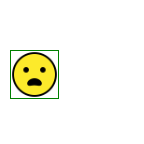

In [6]:
# Visualize one sample
img, box, cls_id = create_sample()
print(box)
plot_bbox(img, box)

In [7]:
# Function to generate samples (in batches)
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, IMG_WIDTH, IMG_HEIGHT, 3))
        y_batch = np.zeros((batch_size, 9))
        box_batch = np.zeros((batch_size, 4))
        for i in range(batch_size):
            image, box, class_id = create_sample()
            # Scale image
            x_batch[i] = image / 255.
            # Set the correct class as 1
            y_batch[i, class_id] = 1.0
            box_batch[i] = np.array([box])
        yield {"image":x_batch}, {"class_out":y_batch, "box_out":box_batch}

In [8]:
# Implementation of Intersection Over Union metric
class Iou(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(Iou, self).__init__(**kwargs)
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            y = y * IMG_WIDTH
            x1, y1, x2, y2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
            return x1, y1, x2, y2
        
        def get_area(points):
            x1, y1, x2, y2 = points
            return tf.math.abs(y2-y1) * tf.math.abs(x2-x1)
        
        yt_x1, yt_y1, yt_x2, yt_y2 = get_box(y_true)
        yp_x1, yp_y1, yp_x2, yp_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(yt_x1, yp_x1)
        i_y1 = tf.maximum(yt_y1, yp_y1)
        i_x2 = tf.minimum(yt_x2, yp_x2)
        i_y2 = tf.minimum(yt_y2, yp_y2)
        
        i_area = get_area((i_x1, i_y1, i_x2, i_y2))
        total_area = get_area(get_box(y_true)) + get_area(get_box(y_pred)) - i_area
        
        iou = tf.math.divide(i_area, total_area)
        
        self.num_ex.assign(1)
        self.total_iou.assign(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

In [9]:
# A function to test the model on random samples during training
def test(model, sample=None):
    if sample is None:
        sample = next(data_generator())
    # Retrieve sample details
    inp, out = sample
    image = inp["image"]
    yt_box = out["box_out"]
    yt_class = np.argmax(out["class_out"], axis=1)
    # Predict sample & Retrieve output
    class_out, yp_box = model.predict(image)
    yp_class_ids = tf.math.argmax(class_out, axis=1)
    
    fig, ax = plt.subplots(1, 6)
    for i in range(min(len(image), 6)):
        yp_class_name = emojis[yp_class_ids[i].numpy()]["class"]
        yt_class_name = emojis[yt_class[i]]["class"]
        image_plotted = plot_bbox(image[i], yt_box[i], yp_box[i], norm=True) # continue

        ax[i].imshow(image_plotted)
        ax[i].set_axis_off()
        ax[i].set_title(f"{yt_class_name} | {yp_class_name}")
    plt.show()

In [10]:
# Callback to predict random samples after each epoch
class ShowTest(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.01
    return max(lr, 5e-5)

In [11]:
# CNN Architecture

inp = Input(shape=(IMG_WIDTH, IMG_HEIGHT,3), name='image')
x = inp
for i in range(5):
    n_filters = 2 ** (4+i)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(n_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(4, name='box_out')(x)

model = Model(inp, [class_out, box_out])
model.summary()

2022-04-03 03:14:21.049096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 03:14:21.191158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 03:14:21.191861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 03:14:21.192958: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 144, 144, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 144, 144, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 144, 144, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# CNN Architecture
![](https://lh5.googleusercontent.com/jM21yNYHPqMaSUglR_jRuTr3xLaauuFOnIlManAl14ovogB9LjV8su2WU3CZQdx7XGR1Axp3EFjb54YJfUS4=w1366-h657-rw)

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    loss={
        "class_out":"categorical_crossentropy",
        "box_out":"mse"
    },
    metrics={
        "class_out":"accuracy",
        "box_out":Iou(name="iou")
    },
    optimizer=adam
)

2022-04-03 03:14:23.785751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-03 03:14:26.534033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


500/500 [==============================] - 22s 27ms/step - loss: 129.5476 - class_out_loss: 5.8516 - box_out_loss: 123.6960 - class_out_accuracy: 0.1241 - box_out_iou: 0.8606


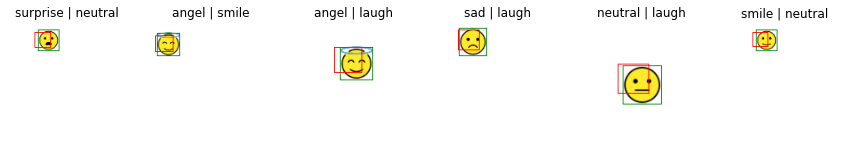

Epoch 2/50
500/500 [==============================] - 14s 27ms/step - loss: 5.8827 - class_out_loss: 2.7082 - box_out_loss: 3.1746 - class_out_accuracy: 0.2734 - box_out_iou: 0.8988


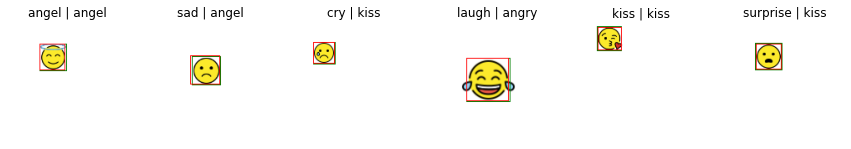

Epoch 3/50
500/500 [==============================] - 14s 27ms/step - loss: 4.8887 - class_out_loss: 1.6775 - box_out_loss: 3.2111 - class_out_accuracy: 0.5089 - box_out_iou: 0.8303


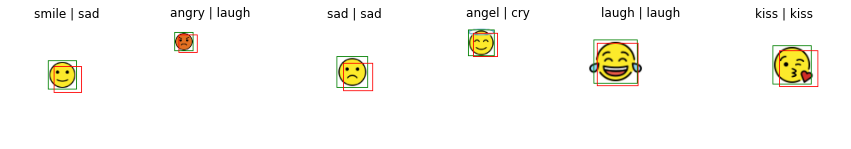

Epoch 4/50
500/500 [==============================] - 14s 27ms/step - loss: 3.9740 - class_out_loss: 1.0729 - box_out_loss: 2.9012 - class_out_accuracy: 0.6495 - box_out_iou: 0.9052


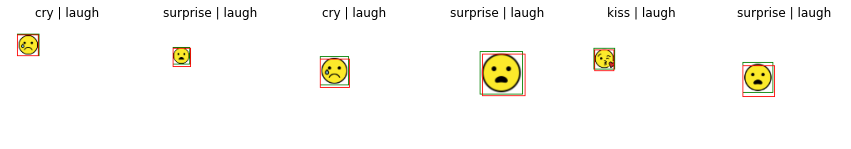

Epoch 5/50
500/500 [==============================] - 14s 27ms/step - loss: 1.1071 - class_out_loss: 0.5575 - box_out_loss: 0.5496 - class_out_accuracy: 0.7449 - box_out_iou: 0.9539


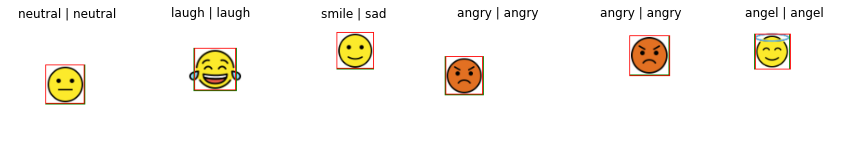

Epoch 6/50
500/500 [==============================] - 14s 27ms/step - loss: 0.8782 - class_out_loss: 0.4845 - box_out_loss: 0.3937 - class_out_accuracy: 0.7659 - box_out_iou: 0.9379


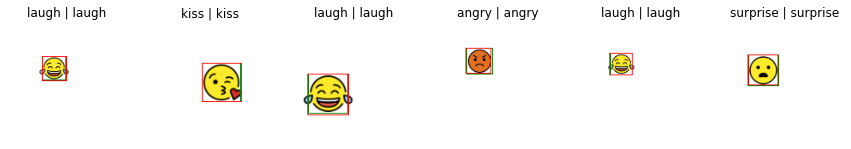

Epoch 7/50
500/500 [==============================] - 14s 28ms/step - loss: 0.7894 - class_out_loss: 0.4569 - box_out_loss: 0.3325 - class_out_accuracy: 0.7794 - box_out_iou: 0.9509


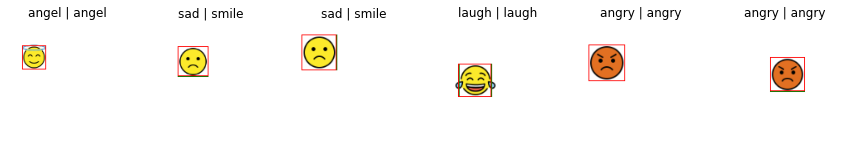

Epoch 8/50
500/500 [==============================] - 13s 27ms/step - loss: 0.7675 - class_out_loss: 0.4594 - box_out_loss: 0.3081 - class_out_accuracy: 0.7711 - box_out_iou: 0.9441


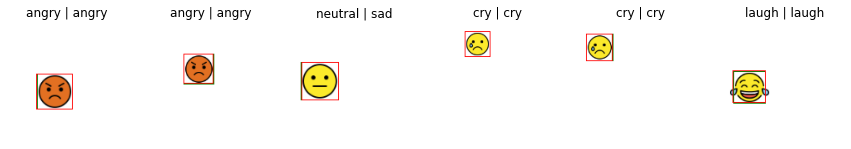

Epoch 9/50
500/500 [==============================] - 14s 27ms/step - loss: 0.7257 - class_out_loss: 0.4530 - box_out_loss: 0.2727 - class_out_accuracy: 0.7720 - box_out_iou: 0.9633


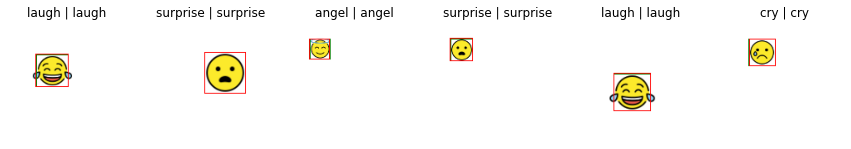

Epoch 10/50
500/500 [==============================] - 14s 28ms/step - loss: 0.6685 - class_out_loss: 0.4284 - box_out_loss: 0.2401 - class_out_accuracy: 0.7890 - box_out_iou: 0.9672


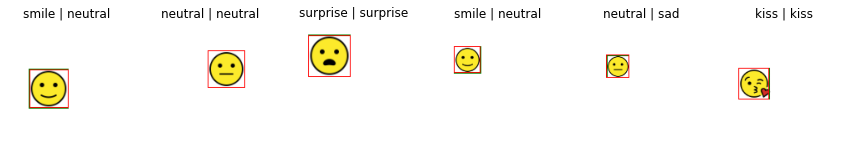

Epoch 11/50
500/500 [==============================] - 14s 27ms/step - loss: 0.6709 - class_out_loss: 0.4305 - box_out_loss: 0.2403 - class_out_accuracy: 0.7846 - box_out_iou: 0.9612


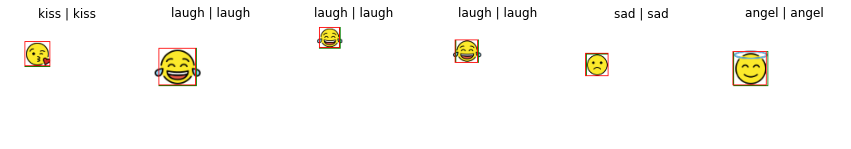

Epoch 12/50
500/500 [==============================] - 14s 28ms/step - loss: 0.6622 - class_out_loss: 0.4358 - box_out_loss: 0.2264 - class_out_accuracy: 0.7821 - box_out_iou: 0.9570


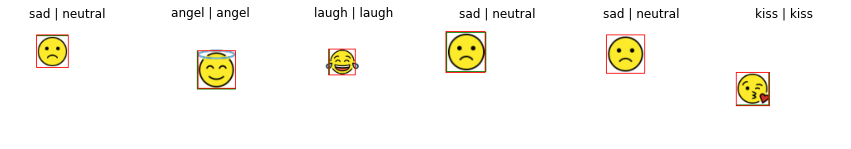

Epoch 13/50
500/500 [==============================] - 14s 28ms/step - loss: 0.6329 - class_out_loss: 0.4134 - box_out_loss: 0.2195 - class_out_accuracy: 0.7970 - box_out_iou: 0.9580


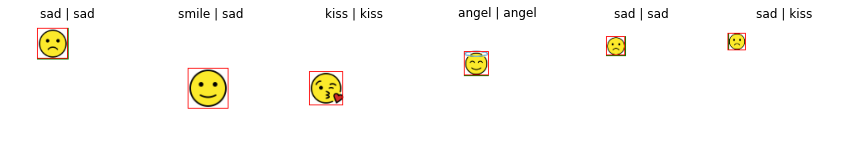

Epoch 14/50
500/500 [==============================] - 14s 27ms/step - loss: 0.6067 - class_out_loss: 0.4197 - box_out_loss: 0.1870 - class_out_accuracy: 0.7970 - box_out_iou: 0.9693


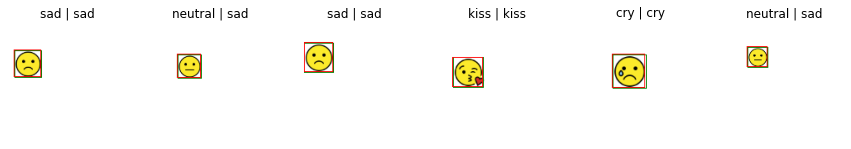

Epoch 15/50
500/500 [==============================] - 14s 27ms/step - loss: 0.5721 - class_out_loss: 0.3875 - box_out_loss: 0.1845 - class_out_accuracy: 0.8183 - box_out_iou: 0.9544


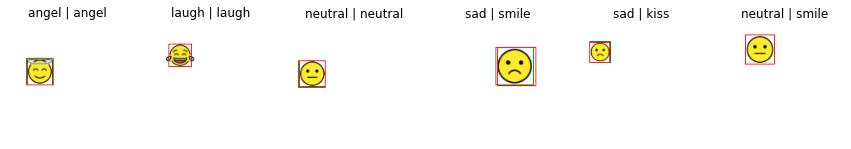

Epoch 16/50
500/500 [==============================] - 13s 27ms/step - loss: 0.5559 - class_out_loss: 0.3739 - box_out_loss: 0.1821 - class_out_accuracy: 0.8240 - box_out_iou: 0.9680


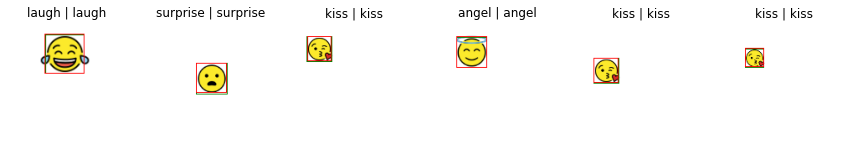

Epoch 17/50
500/500 [==============================] - 14s 28ms/step - loss: 0.4936 - class_out_loss: 0.3192 - box_out_loss: 0.1744 - class_out_accuracy: 0.8652 - box_out_iou: 0.9580


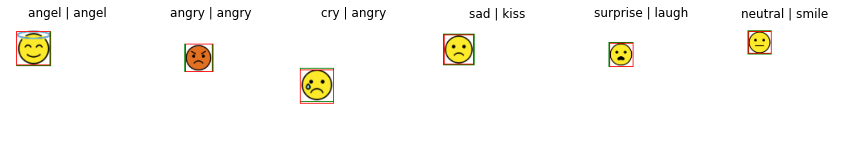

Epoch 18/50
500/500 [==============================] - 14s 27ms/step - loss: 0.4716 - class_out_loss: 0.3054 - box_out_loss: 0.1663 - class_out_accuracy: 0.8730 - box_out_iou: 0.9586


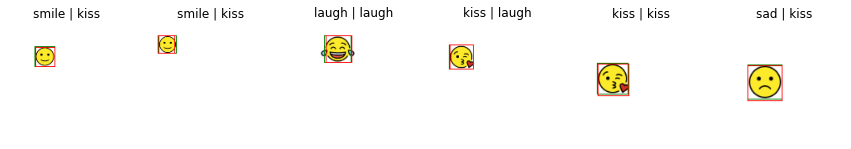

Epoch 19/50
500/500 [==============================] - 14s 28ms/step - loss: 0.4260 - class_out_loss: 0.2451 - box_out_loss: 0.1810 - class_out_accuracy: 0.9032 - box_out_iou: 0.9556


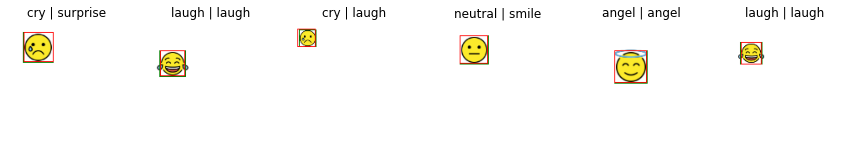

Epoch 20/50
500/500 [==============================] - 14s 28ms/step - loss: 0.3933 - class_out_loss: 0.2185 - box_out_loss: 0.1749 - class_out_accuracy: 0.9218 - box_out_iou: 0.9651


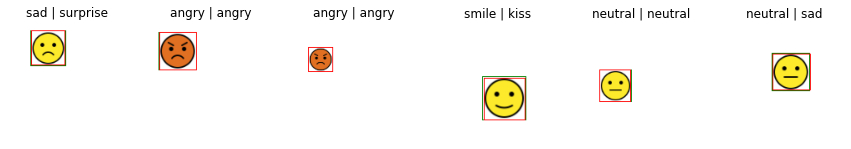

Epoch 21/50
500/500 [==============================] - 14s 27ms/step - loss: 0.3437 - class_out_loss: 0.1767 - box_out_loss: 0.1669 - class_out_accuracy: 0.9376 - box_out_iou: 0.9594


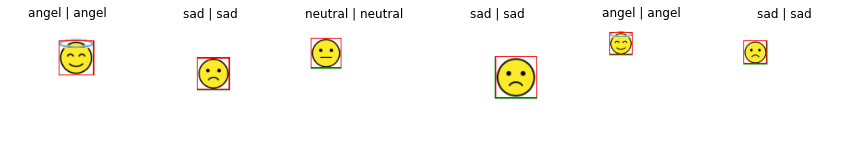

Epoch 22/50
500/500 [==============================] - 14s 28ms/step - loss: 0.3155 - class_out_loss: 0.1410 - box_out_loss: 0.1745 - class_out_accuracy: 0.9526 - box_out_iou: 0.9551


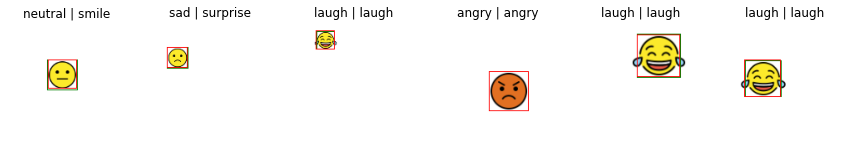

Epoch 23/50
500/500 [==============================] - 13s 27ms/step - loss: 0.2701 - class_out_loss: 0.1191 - box_out_loss: 0.1510 - class_out_accuracy: 0.9607 - box_out_iou: 0.9742


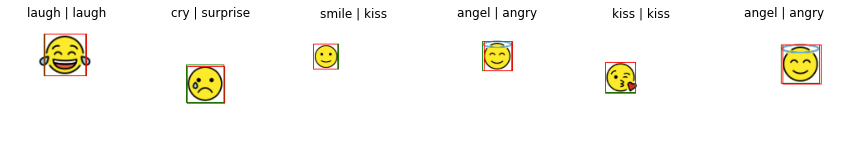

Epoch 24/50
500/500 [==============================] - 14s 28ms/step - loss: 0.2632 - class_out_loss: 0.1062 - box_out_loss: 0.1571 - class_out_accuracy: 0.9646 - box_out_iou: 0.9744


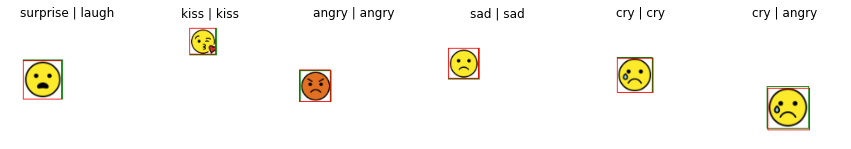

Epoch 25/50
500/500 [==============================] - 14s 28ms/step - loss: 0.2438 - class_out_loss: 0.0949 - box_out_loss: 0.1490 - class_out_accuracy: 0.9680 - box_out_iou: 0.9663


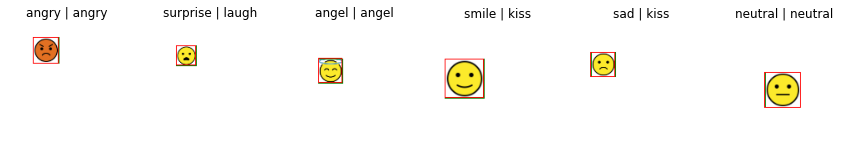

Epoch 26/50
500/500 [==============================] - 14s 27ms/step - loss: 0.2366 - class_out_loss: 0.0835 - box_out_loss: 0.1531 - class_out_accuracy: 0.9720 - box_out_iou: 0.9701


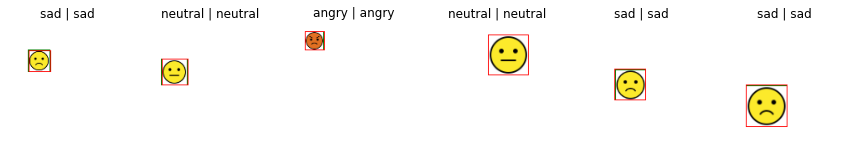

Epoch 27/50
500/500 [==============================] - 14s 28ms/step - loss: 0.2079 - class_out_loss: 0.0663 - box_out_loss: 0.1416 - class_out_accuracy: 0.9808 - box_out_iou: 0.9644


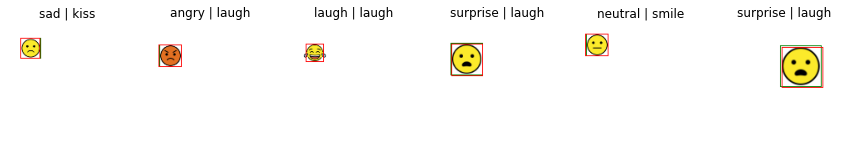

Epoch 28/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1791 - class_out_loss: 0.0493 - box_out_loss: 0.1298 - class_out_accuracy: 0.9869 - box_out_iou: 0.9698


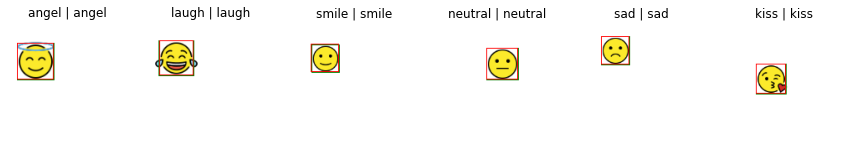

Epoch 29/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1483 - class_out_loss: 0.0400 - box_out_loss: 0.1082 - class_out_accuracy: 0.9902 - box_out_iou: 0.9475


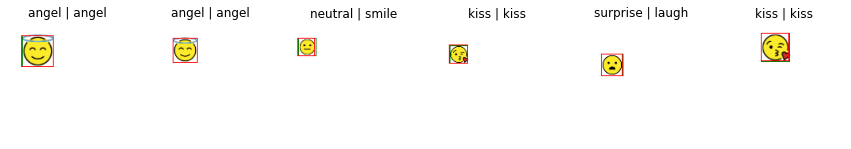

Epoch 30/50
500/500 [==============================] - 13s 27ms/step - loss: 0.1676 - class_out_loss: 0.0425 - box_out_loss: 0.1251 - class_out_accuracy: 0.9877 - box_out_iou: 0.9665


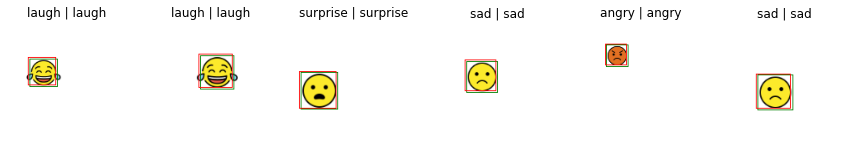

Epoch 31/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1625 - class_out_loss: 0.0403 - box_out_loss: 0.1222 - class_out_accuracy: 0.9893 - box_out_iou: 0.9759


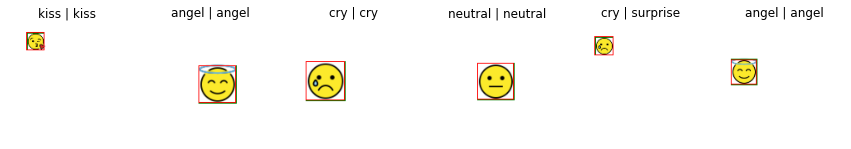

Epoch 32/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1385 - class_out_loss: 0.0275 - box_out_loss: 0.1110 - class_out_accuracy: 0.9935 - box_out_iou: 0.9816


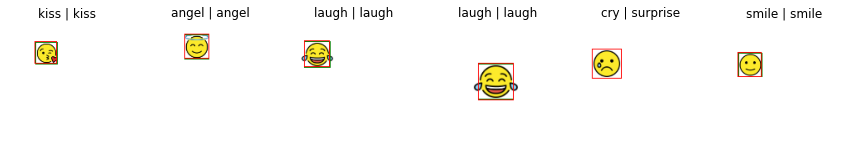

Epoch 33/50
500/500 [==============================] - 14s 27ms/step - loss: 0.1118 - class_out_loss: 0.0245 - box_out_loss: 0.0873 - class_out_accuracy: 0.9946 - box_out_iou: 0.9736


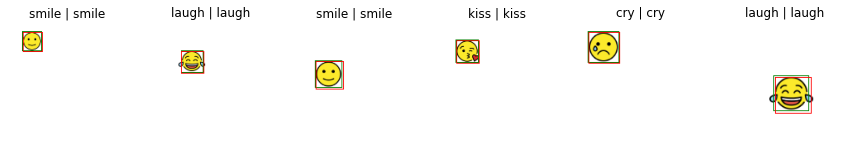

Epoch 34/50
500/500 [==============================] - 14s 29ms/step - loss: 0.1275 - class_out_loss: 0.0245 - box_out_loss: 0.1030 - class_out_accuracy: 0.9948 - box_out_iou: 0.9593


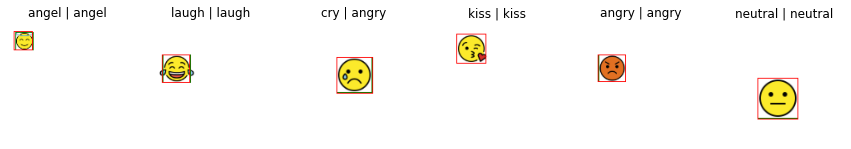

Epoch 35/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1058 - class_out_loss: 0.0157 - box_out_loss: 0.0901 - class_out_accuracy: 0.9981 - box_out_iou: 0.9743


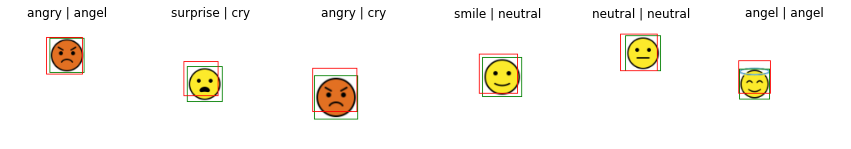

Epoch 36/50
500/500 [==============================] - 13s 27ms/step - loss: 0.1268 - class_out_loss: 0.0219 - box_out_loss: 0.1049 - class_out_accuracy: 0.9952 - box_out_iou: 0.9809


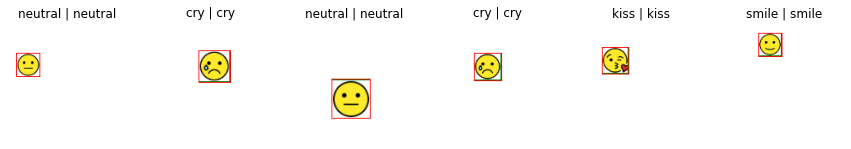

Epoch 37/50
500/500 [==============================] - 14s 29ms/step - loss: 0.1084 - class_out_loss: 0.0143 - box_out_loss: 0.0941 - class_out_accuracy: 0.9979 - box_out_iou: 0.9756


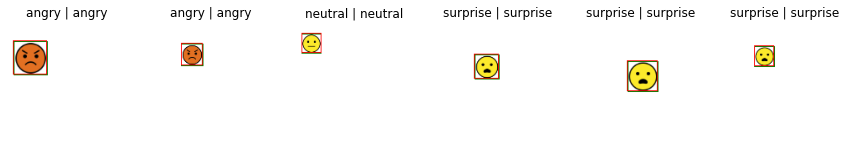

Epoch 38/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1134 - class_out_loss: 0.0144 - box_out_loss: 0.0990 - class_out_accuracy: 0.9973 - box_out_iou: 0.9763


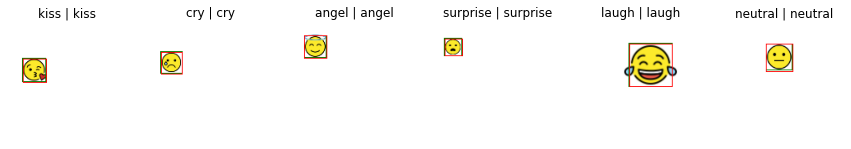

Epoch 39/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1100 - class_out_loss: 0.0172 - box_out_loss: 0.0928 - class_out_accuracy: 0.9964 - box_out_iou: 0.9741


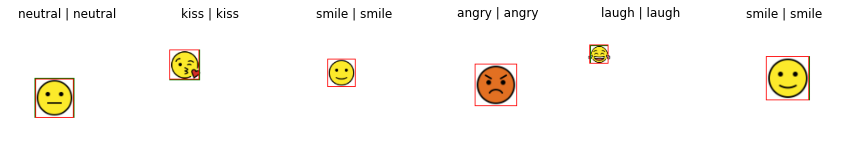

Epoch 40/50
500/500 [==============================] - 14s 28ms/step - loss: 0.1010 - class_out_loss: 0.0211 - box_out_loss: 0.0799 - class_out_accuracy: 0.9950 - box_out_iou: 0.9663


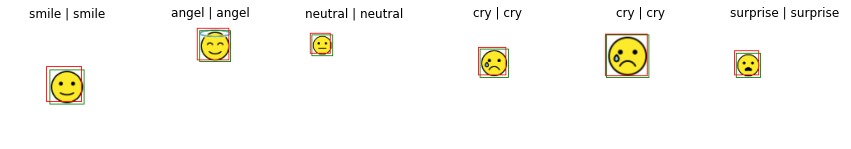

Epoch 41/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0954 - class_out_loss: 0.0128 - box_out_loss: 0.0826 - class_out_accuracy: 0.9979 - box_out_iou: 0.9776


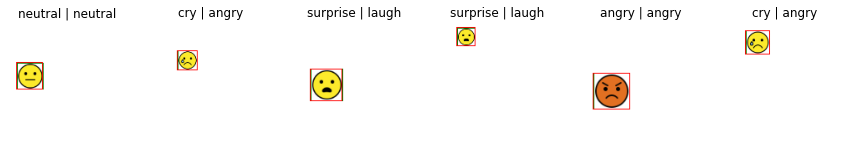

Epoch 42/50
500/500 [==============================] - 15s 29ms/step - loss: 0.0880 - class_out_loss: 0.0080 - box_out_loss: 0.0800 - class_out_accuracy: 0.9994 - box_out_iou: 0.9733


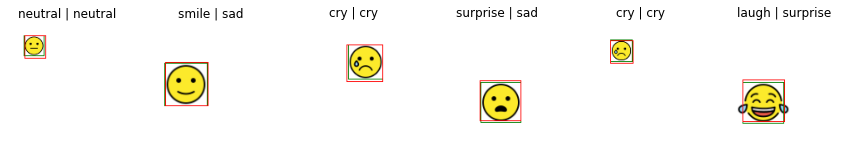

Epoch 43/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0845 - class_out_loss: 0.0083 - box_out_loss: 0.0761 - class_out_accuracy: 0.9989 - box_out_iou: 0.9794


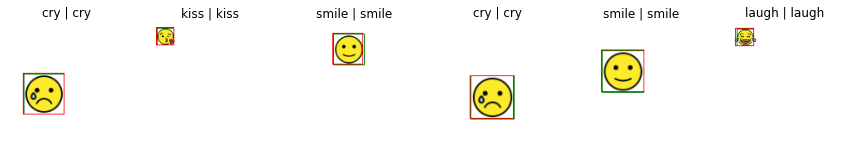

Epoch 44/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0936 - class_out_loss: 0.0116 - box_out_loss: 0.0821 - class_out_accuracy: 0.9976 - box_out_iou: 0.9769


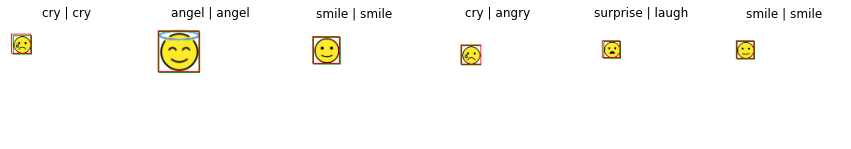

Epoch 45/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0831 - class_out_loss: 0.0085 - box_out_loss: 0.0745 - class_out_accuracy: 0.9987 - box_out_iou: 0.9401


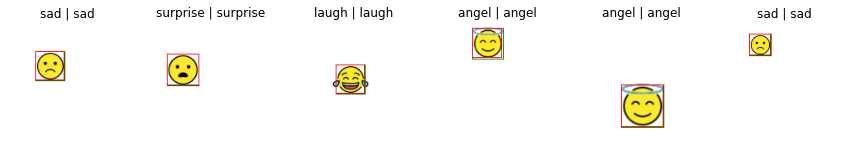

Epoch 46/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0861 - class_out_loss: 0.0094 - box_out_loss: 0.0767 - class_out_accuracy: 0.9979 - box_out_iou: 0.9812


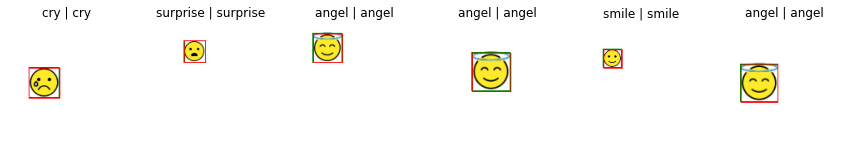

Epoch 47/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0749 - class_out_loss: 0.0060 - box_out_loss: 0.0688 - class_out_accuracy: 0.9995 - box_out_iou: 0.9808


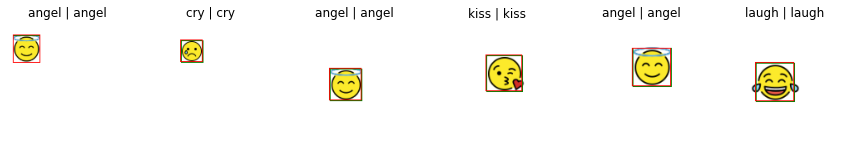

Epoch 48/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0697 - class_out_loss: 0.0064 - box_out_loss: 0.0633 - class_out_accuracy: 0.9991 - box_out_iou: 0.9806


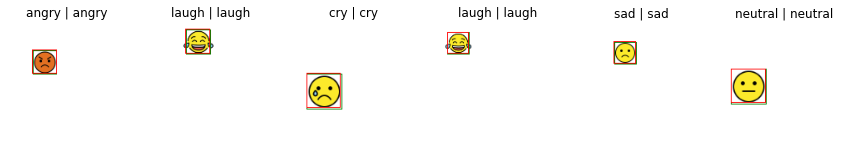

Epoch 49/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0747 - class_out_loss: 0.0053 - box_out_loss: 0.0694 - class_out_accuracy: 0.9996 - box_out_iou: 0.9825


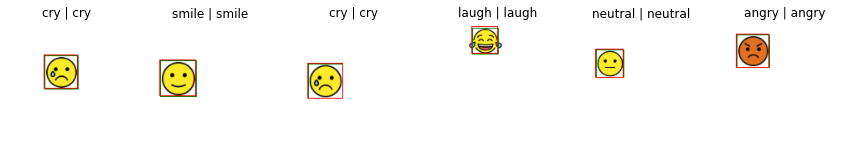

Epoch 50/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0819 - class_out_loss: 0.0044 - box_out_loss: 0.0775 - class_out_accuracy: 0.9999 - box_out_iou: 0.9802


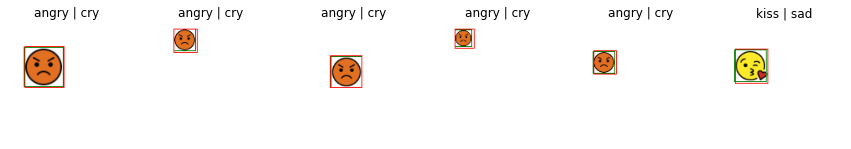

In [13]:
history = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTest(),
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    ]
)

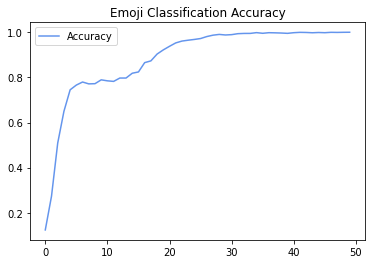

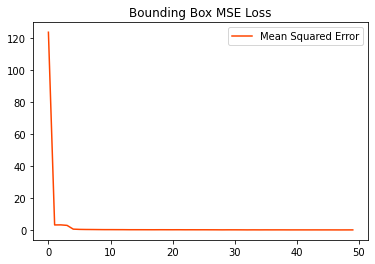

In [14]:
# Visualize Loss & Accuracy

%matplotlib inline
acc = history.history['class_out_accuracy']
loss = history.history['box_out_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'cornflowerblue', label='Accuracy')
plt.title('Emoji Classification Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'orangered', label='Mean Squared Error')
plt.title('Bounding Box MSE Loss')
plt.legend()

plt.show()